In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import  numpy as np

from time import time
from datetime import timedelta

# importing pacakge 
import sys         
sys.path.append(r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\libraries')        

from main import *
from FinancialData import *

## Data extraction & Portfolio construction :

In [2]:

FX_path =r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Data\FX'

In [3]:
ZCR = ZC_Data_extractor("R:/DR-NATIXIS/ERM/MCRM/LeaderExpert/Stagiaires/2023")
ZC = zero_coupon_bonds(ZCR, 3) # We chose 3 as degree of the Spline Interpolation 

In [4]:
nbr_fx =  10
nbr_swap = 400
portfolio = Multi_FX_irs_portfolio( nbr_fx, nbr_swap, first_date=[0], freq=[0.25, 0.5, 1], Nominal=[10000],
                 maturity=list(np.arange(1, 7 + 0.5, 0.5)),
                 fix_rate=[0.02, 0.05], exercice=['payer', 'reciver'], SEED=1999)


portfolio.irs_specs

array([(0., 0.25,  60000., 0.04473561, 2.5, 'reciver', 0),
       (0., 0.25,  90000., 0.0495388 , 1. , 'payer', 2),
       (0., 0.25,  80000., 0.04679434, 1. , 'payer', 4),
       (0., 0.5 ,  40000., 0.02958941, 7. , 'payer', 2),
       (0., 1.  , 100000., 0.0377977 , 6.5, 'reciver', 5),
       (0., 1.  ,  30000., 0.02586477, 4.5, 'reciver', 1),
       (0., 1.  ,  10000., 0.0458065 , 2. , 'reciver', 4),
       (0., 0.5 ,  40000., 0.04592901, 2. , 'payer', 0),
       (0., 1.  ,  20000., 0.02235853, 6.5, 'payer', 3),
       (0., 0.25, 100000., 0.04150736, 2. , 'reciver', 0),
       (0., 0.25, 100000., 0.04176027, 4. , 'payer', 6),
       (0., 0.25,  80000., 0.04205143, 3. , 'reciver', 2),
       (0., 0.5 ,  90000., 0.04384751, 3. , 'payer', 9),
       (0., 0.25, 100000., 0.03102544, 3. , 'payer', 4),
       (0., 0.25,  90000., 0.04814816, 5.5, 'payer', 8),
       (0., 0.5 ,  90000., 0.03369468, 1. , 'payer', 1),
       (0., 0.25,  60000., 0.04944313, 7. , 'reciver', 0),
       (0., 1.  ,

In [5]:
port_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Data\portfolio'
portfolio.save_as_excel(port_path, '\port400irs10fx.xlsx')

## Model parameters & diffusion :

In [6]:
def Random_correlation_matrix(n):
    rho = np.random.uniform(0, 1, (n, n))
    rho = (rho + rho.T) / 2
    np.fill_diagonal(rho, 1)
    rho = np.round(rho, 3)
    return rho

model_params = Model_params(nbr_fx, from_excel=True, path=FX_path+'\Fx_rate.xlsx')
cov_matrix = Random_correlation_matrix(2*nbr_fx-1)
model_params.LGM_params, model_params.FX_params, cov_matrix

(array([(0.01916854, 0.02269547), (0.01415671, 0.01821296),
        (0.01396354, 0.01079556), (0.01957002, 0.01734392),
        (0.01300581, 0.02001783), (0.01236911, 0.00993169),
        (0.01711624, 0.01424422), (0.01991893, 0.01617539),
        (0.01359895, 0.02271345), (0.01465775, 0.01271447)],
       dtype=[('mean rev', '<f4'), ('sigma', '<f4')]),
 array([(1.   , 0.        , 'EUR'), (0.83 , 0.00942824, 'USD'),
        (0.777, 0.03739527, 'JPY'), (1.156, 0.04431963, 'GBP'),
        (0.645, 0.05892205, 'AUD'), (0.656, 0.01757793, 'CAD'),
        (0.136, 0.03468985, 'CNY'), (0.908, 0.03025514, 'CHF'),
        (0.107, 0.03609272, 'HKD'), (0.603, 0.02962503, 'NZD')],
       dtype=[('rate', '<f4'), ('vol', '<f4'), ('currency', '<U3')]),
 array([[1.   , 0.6  , 0.732, 0.575, 0.413, 0.586, 0.232, 0.468, 0.785,
         0.384, 0.635, 0.573, 0.878, 0.654, 0.429, 0.925, 0.254, 0.55 ,
         0.81 ],
        [0.6  , 1.   , 0.578, 0.689, 0.45 , 0.601, 0.37 , 0.376, 0.289,
         0.358, 0.75

In [7]:
T = portfolio.last_maturity
n =  int(T*360) +1 
NBR_SCENARIOS = 10000

tt= time()
diffusion = Multi_FX_Diffusion(0, T, n, [ZC for i in range(nbr_fx)], model_params, NBR_SCENARIOS, pb_measure='Risk Neutral',
                 cov_matrix= cov_matrix)
print( 'Diffusion Time',"{}".format(str( timedelta( seconds=round(time()-tt) ) )) )

# SAVE diffusion
diff_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Data\diffusion'
diffusion.save_as_pickle(diff_path,'\MC10000p400s10f')

Diffusion Time 0:00:39


## CVA calculation : 

In [10]:
#recovery rate & defult probability parameter :
R, lamda = 0.4, 0.02

Total Calculation Time : 0:34:52


,Nodes Number,Mtm,CVA MC,time
0,50.0,-18473.9,1250.7,110.4
1,100.0,-18473.9,1237.6,215.0
2,300.0,-18473.9,1241.3,669.5
3,500.0,-18473.9,1240.4,1097.1


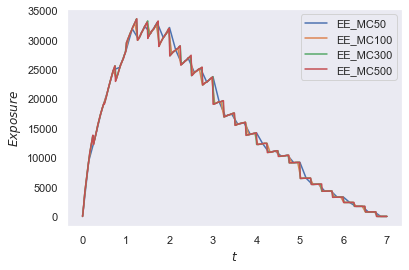

In [12]:
img_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Results\Images'

discretisations = [50,100,300,500]

mtm = np.mean(portfolio.Mtm(0, diffusion, [ZC for i in range(nbr_fx)]))
benchmark_df =  pd.DataFrame(columns=['Nodes Number', 'Mtm' ,'CVA MC', 'time'])

start = time()
for n in discretisations :
    time_grid = np.linspace(0,T,n)
    
    mc_start = time()
    
    EE = np.array([ Expected_exposure_MC(t, portfolio, diffusion, [ZC for i in range(nbr_fx)]) for t in time_grid])
    PD = np.array([ lamda * np.exp(-lamda *t) for t in time_grid])
    Y = (1-R)*EE*PD
    cva = (np.diff(time_grid)*Y[1:]).sum()
    
    benchmark_df.loc[len(benchmark_df)] = [ round(n) , mtm,cva, time() - mc_start]
   
    plt.plot(time_grid, EE, label="EE_MC"+str(n))
    plt.legend()
    plt.xlabel(r"$t$")
    plt.ylabel(r"$Exposure$")
    plt.grid(False)
    plt.savefig(img_path+'\EE_MC_P600sf10'+'.png')
    
print('Total Calculation Time :' , "{}".format(str( timedelta( seconds=round(time()-start) ) )))
benchmark_df.round(1)

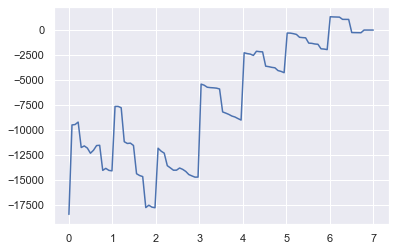

In [13]:
# Plot mtm to see the smothness or get ben hriz portfolio !
mtm_tgrid = np.linspace(0,T,100)
Mtm_mean = np.array([ portfolio.Mtm(t, diffusion, [ZC for i in range(nbr_fx)]).mean() for t in mtm_tgrid])
plt.plot(mtm_tgrid, Mtm_mean)

In [14]:
# # Save Results :
import pickle
result_path = r'C:\Users\omirinioui\PycharmProjects\Hadil_proj\Code\Bayesian Quad for CVA\BQ CVA Swaps Multi RF\Results\Full MC'
with open(result_path+'\EE_MC_P400sf10' ,'wb') as f:
    pickle.dump(benchmark_df,f)
    pickle.dump(EE,f)